### Familiarize yourself with the HR dataset 

In this [dataset](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv), there are 14,999 rows, 10 columns, and these variables: 

Variable  |Description |
-----|-----| 
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

In [43]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree
import pickle

In [44]:
df0 = pd.read_csv("data/HR_comma_sep.csv")
df0.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years Department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

## Step 2. Data Exploration ( EDA and data cleaning)

- Understand your variables
- Clean your dataset (missing data, redundant data, outliers) 



### Gather basic information about the data

In [45]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### Gather descriptive statistics about the data

In [46]:
df0.describe()

satisfaction_level  last_evaluation  number_project  \
count        14999.000000     14999.000000    14999.000000   
mean             0.612834         0.716102        3.803054   
std              0.248631         0.171169        1.232592   
min              0.090000         0.360000        2.000000   
25%              0.440000         0.560000        3.000000   
50%              0.640000         0.720000        4.000000   
75%              0.820000         0.870000        5.000000   
max              1.000000         1.000000        7.000000   

       average_montly_hours  time_spend_company  Work_accident          left  \
count          14999.000000        14999.000000   14999.000000  14999.000000   
mean             201.050337            3.498233       0.144610      0.238083   
std               49.943099            1.460136       0.351719      0.425924   
min               96.000000            2.000000       0.000000      0.000000   
25%              156.000000            3.000000       0.000000      0.000000   
50%              200.000000            3.000000       0.000000      0.000000   
75%              245.000000            4.000000       0.000000      0.000000   
max              310.000000           10.000000       1.000000      1.000000   

       promotion_last_5years  
count           14999.000000  
mean                0.021268  
std                 0.144281  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.000000  
max                 1.000000

In [47]:
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [48]:
# Rename columns as needed
df0 = df0.rename(columns={'Work_accident': 'work_accident',
                          'average_montly_hours': 'average_monthly_hours',
                          'time_spend_company': 'tenure',
                          'Department': 'department'})

df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

### Check missing values

In [49]:
df0.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

There are no missing values in the data.

### Check duplicates

Check for any duplicate entries in the data.

In [50]:
df0.duplicated().sum()

3008

3,008 rows contain duplicates. That is 20% of the data.

In [51]:
df0[df0.duplicated()].head()

satisfaction_level  last_evaluation  number_project  \
396                 0.46             0.57               2   
866                 0.41             0.46               2   
1317                0.37             0.51               2   
1368                0.41             0.52               2   
1461                0.42             0.53               2   

      average_monthly_hours  tenure  work_accident  left  \
396                     139       3              0     1   
866                     128       3              0     1   
1317                    127       3              0     1   
1368                    132       3              0     1   
1461                    142       3              0     1   

      promotion_last_5years  department  salary  
396                       0       sales     low  
866                       0  accounting     low  
1317                      0       sales  medium  
1368                      0       RandD     low  
1461                      0       sales     low

In [52]:
# Drop duplicates and save resulting dataframe in a new variable as needed
df1 = df0.drop_duplicates(keep='first')
df1.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years department  salary  
0       3              0     1                      0      sales     low  
1       6              0     1                      0      sales  medium  
2       4              0     1                      0      sales  medium  
3       5              0     1                      0      sales     low  
4       3              0     1                      0      sales     low

### Check outliers

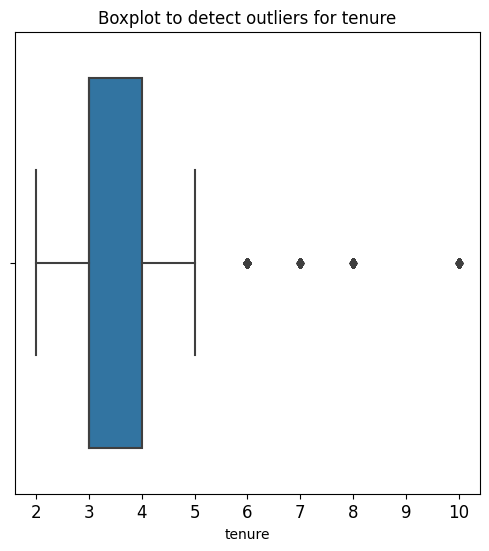

In [53]:
plt.figure(figsize=(6,6))
plt.title('Boxplot to detect outliers for tenure', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df1['tenure'])
plt.show()

The boxplot above shows that there are outliers in the `tenure` variable. 

It would be helpful to investigate how many rows in the data contain outliers in the `tenure` column.

In [54]:
# Determine the number of rows containing outliers 
# Compute the 25th percentile value in `tenure`
percentile25 = df1['tenure'].quantile(0.25)
# Compute the 75th percentile value in `tenure`
percentile75 = df1['tenure'].quantile(0.75)
# Compute the interquartile range in `tenure`
iqr = percentile75 - percentile25

# Define the upper limit and lower limit for non-outlier values in `tenure`
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

# Identify subset of data containing outliers in `tenure`
outliers = df1[(df1['tenure'] > upper_limit) | (df1['tenure'] < lower_limit)]

# Count how many rows in the data contain outliers in `tenure`
print("Number of rows in the data containing outliers in `tenure`:", len(outliers))

Lower limit: 1.5
Upper limit: 5.5
Number of rows in the data containing outliers in `tenure`: 824


Certain types of models are more sensitive to outliers than others. When you get to the stage of building your model, consider whether to remove these outliers based on the type of model you decide to use.

 ## Data Exploration (Continue EDA)

Begin by understanding how many employees left and what percentage of all employees this figure represents.

In [55]:
print(df1['left'].value_counts())
print()
# Get percentages of people who left vs. stayed
print(df1['left'].value_counts(normalize=True))

0    10000
1     1991
Name: left, dtype: int64

0    0.833959
1    0.166041
Name: left, dtype: float64


### Data visualizations

 create plots to visualize relationships between variables in the data.

creating a stacked boxplot showing `average_monthly_hours` distributions for `number_project`, comparing the distributions of employees who stayed versus those who left.

Box plots are very useful in visualizing distributions within data, but they can be deceiving without the context of how big the sample sizes that they represent are. So, you could also plot a stacked histogram to visualize the distribution of `number_project` for those who stayed and those who left.

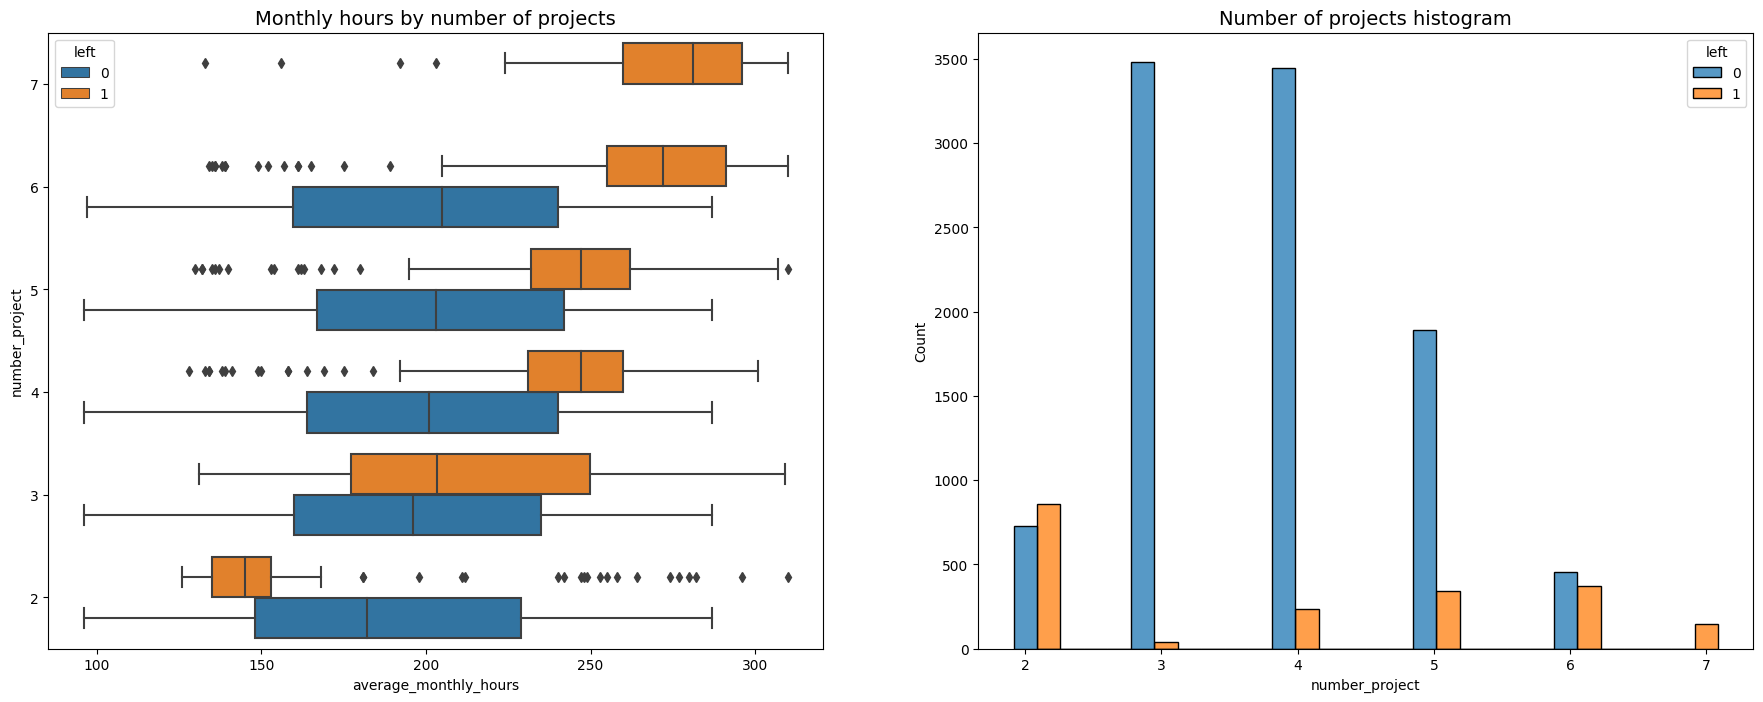

In [56]:
fig, ax = plt.subplots(1, 2, figsize = (22,8))
# Create boxplot showing `average_monthly_hours` distributions for `number_project`, comparing employees who stayed versus those who left
sns.boxplot(data=df1, x='average_monthly_hours', y='number_project', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects', fontsize='14')
# Create histogram showing distribution of `number_project`, comparing employees who stayed versus those who left
tenure_stay = df1[df1['left']==0]['number_project']
tenure_left = df1[df1['left']==1]['number_project']
sns.histplot(data=df1, x='number_project', hue='left', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Number of projects histogram', fontsize='14')
# Display the plots
plt.show()

It might be natural that people who work on more projects would also work longer hours. This appears to be the case here, with the mean hours of each group (stayed and left) increasing with number of projects worked. However, a few things stand out from this plot.

1. There are two groups of employees who left the company: (A) those who worked considerably less than their peers with the same number of projects, and (B) those who worked much more. Of those in group A, it's possible that they were fired. It's also possible that this group includes employees who had already given their notice and were assigned fewer hours because they were already on their way out the door. For those in group B, it's reasonable to infer that they probably quit. The folks in group B likely contributed a lot to the projects they worked in; they might have been the largest contributors to their projects. 

2. Everyone with seven projects left the company, and the interquartile ranges of this group and those who left with six projects was ~255&ndash;295 hours/month&mdash;much more than any other group. 

3. The optimal number of projects for employees to work on seems to be 3&ndash;4. The ratio of left/stayed is very small for these cohorts.

4. If you assume a work week of 40 hours and two weeks of vacation per year, then the average number of working hours per month of employees working Monday&ndash;Friday `= 50 weeks * 40 hours per week / 12 months = 166.67 hours per month`. This means that, aside from the employees who worked on two projects, every group&mdash;even those who didn't leave the company&mdash;worked considerably more hours than this. It seems that employees here are overworked.

As the next step, you could confirm that all employees with seven projects left.

In [57]:
# Get value counts of stayed/left for employees with 7 projects
df1[df1['number_project']==7]['left'].value_counts()

1    145
Name: left, dtype: int64

This confirms that all employees with 7 projects did leave. 

Next, you could examine the average monthly hours versus the satisfaction levels. 

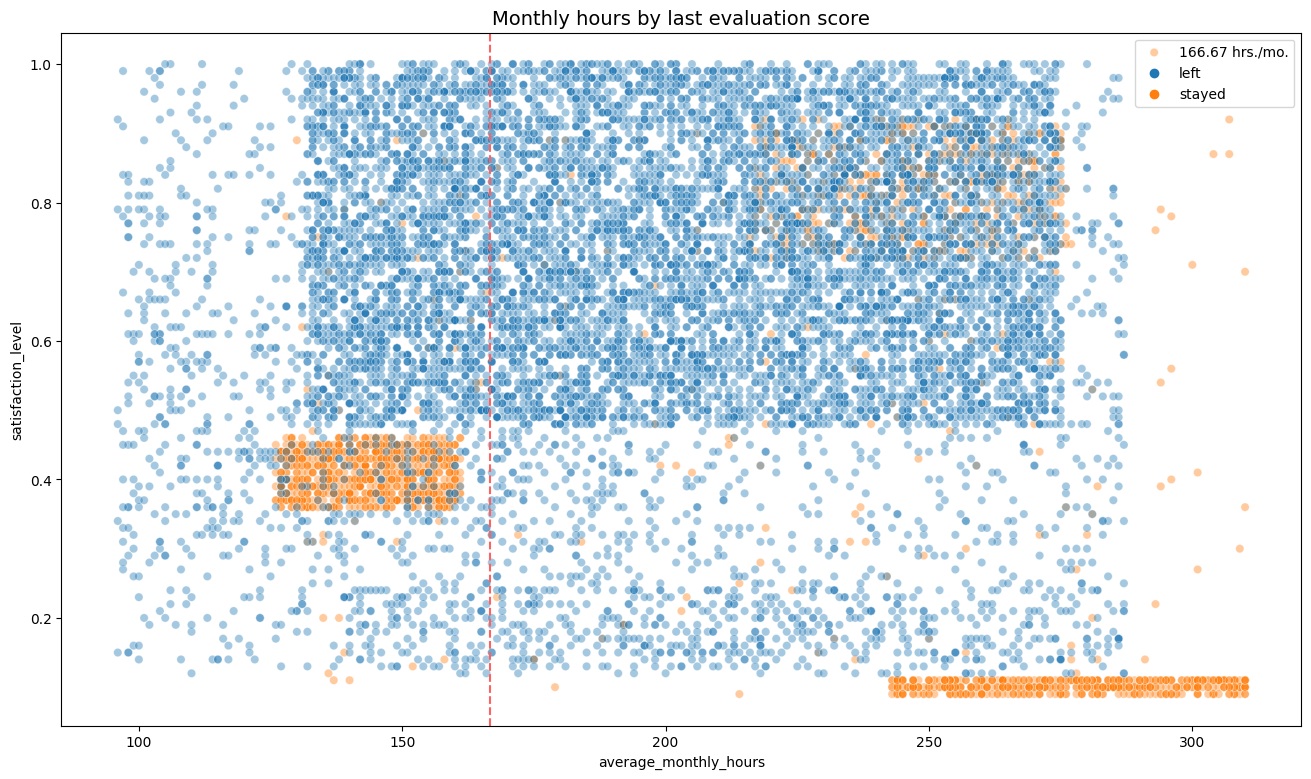

In [58]:
# Create scatterplot of `average_monthly_hours` versus `satisfaction_level`, comparing employees who stayed versus those who left
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df1, x='average_monthly_hours', y='satisfaction_level', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

The scatterplot above shows that there was a sizeable group of employees who worked ~240&ndash;315 hours per month. 315 hours per month is over 75 hours per week for a whole year. It's likely this is related to their satisfaction levels being close to zero. 

The plot also shows another group of people who left, those who had more normal working hours. Even so, their satisfaction was only around 0.4. It's difficult to speculate about why they might have left. It's possible they felt pressured to work more, considering so many of their peers worked more. And that pressure could have lowered their satisfaction levels. 

Finally, there is a group who worked ~210&ndash;280 hours per month, and they had satisfaction levels ranging ~0.7&ndash;0.9. 

Note the strange shape of the distributions here. This is indicative of data manipulation or synthetic data. 

For the next visualization, it might be interesting to visualize satisfaction levels by tenure.

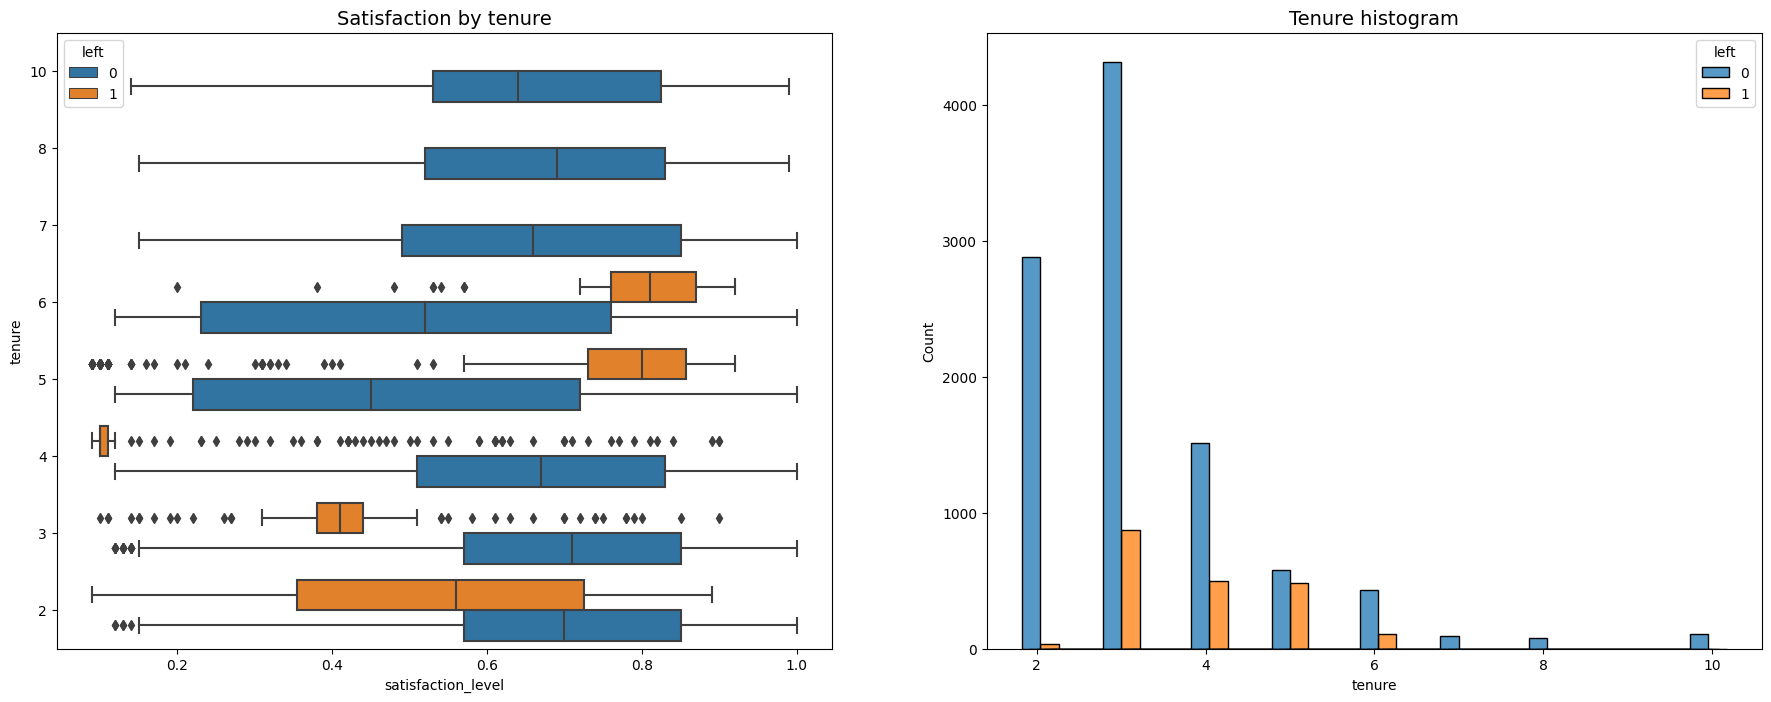

In [59]:
fig, ax = plt.subplots(1, 2, figsize = (22,8))
# Create boxplot showing distributions of `satisfaction_level` by tenure, comparing employees who stayed versus those who left
sns.boxplot(data=df1, x='satisfaction_level', y='tenure', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by tenure', fontsize='14')

# Create histogram showing distribution of `tenure`, comparing employees who stayed versus those who left
tenure_stay = df1[df1['left']==0]['tenure']
tenure_left = df1[df1['left']==1]['tenure']
sns.histplot(data=df1, x='tenure', hue='left', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Tenure histogram', fontsize='14')

plt.show();

There are many observations you could make from this plot.
- Employees who left fall into two general categories: dissatisfied employees with shorter tenures and very satisfied employees with medium-length tenures.
- Four-year employees who left seem to have an unusually low satisfaction level. It's worth investigating changes to company policy that might have affected people specifically at the four-year mark, if possible. 
- The longest-tenured employees didn't leave. Their satisfaction levels aligned with those of newer employees who stayed. 
- The histogram shows that there are relatively few longer-tenured employees. It's possible that they're the higher-ranking, higher-paid employees.

As the next step in analyzing the data, you could calculate the mean and median satisfaction scores of employees who left and those who didn't.

In [60]:
# Calculate mean and median satisfaction scores of employees who left and those who stayed
df1.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])

mean  median
left                  
0     0.667365    0.69
1     0.440271    0.41

As expected, the mean and median satisfaction scores of employees who left are lower than those of employees who stayed. Interestingly, among employees who stayed, the mean satisfaction score appears to be slightly below the median score. This indicates that satisfaction levels among those who stayed might be skewed to the left. 

Next, you could examine salary levels for different tenures.

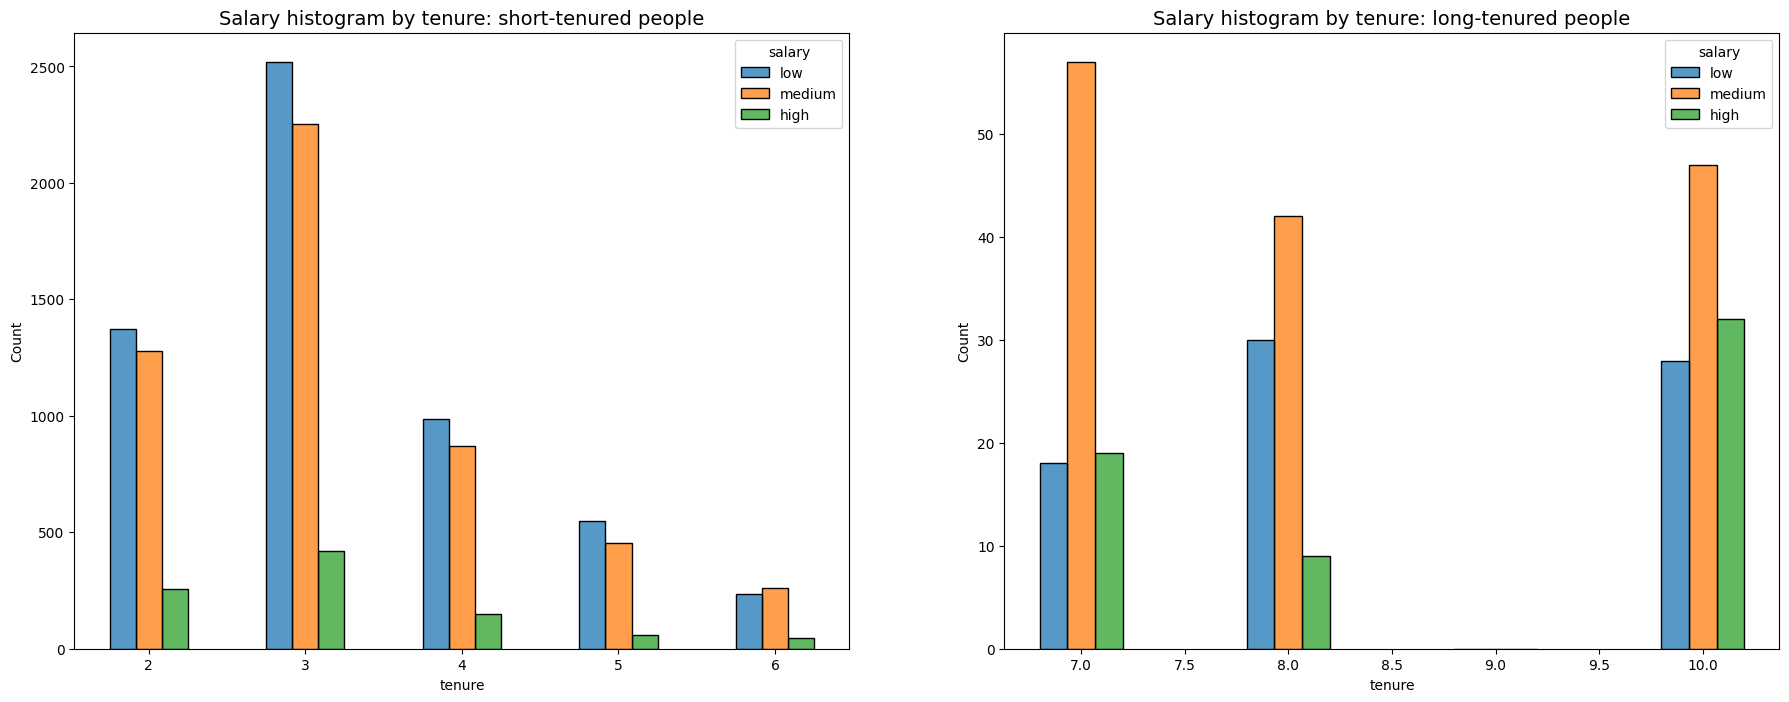

In [61]:

fig, ax = plt.subplots(1, 2, figsize = (22,8))

tenure_short = df1[df1['tenure'] < 7]

tenure_long = df1[df1['tenure'] > 6]

# Plot short-tenured histogram
sns.histplot(data=tenure_short, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5, ax=ax[0])
ax[0].set_title('Salary histogram by tenure: short-tenured people', fontsize='14')

# Plot long-tenured histogram
sns.histplot(data=tenure_long, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.4, ax=ax[1])
ax[1].set_title('Salary histogram by tenure: long-tenured people', fontsize='14');

The plots above show that long-tenured employees were not disproportionately comprised of higher-paid employees. 

Next, you could explore whether there's a correlation between working long hours and receiving high evaluation scores. You could create a scatterplot of `average_monthly_hours` versus `last_evaluation`.

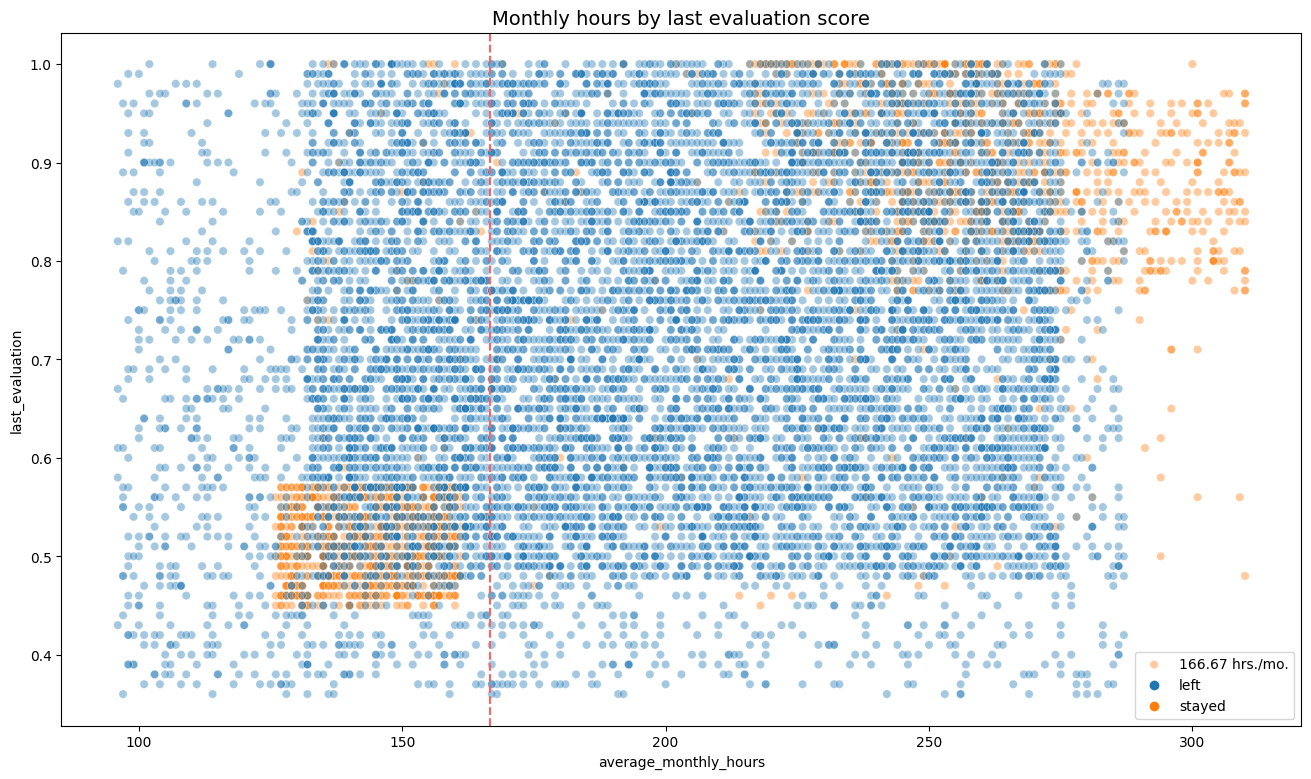

In [62]:
# Create scatterplot of `average_monthly_hours` versus `last_evaluation`
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df1, x='average_monthly_hours', y='last_evaluation', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

The following observations can be made from the scatterplot above:
- The scatterplot indicates two groups of employees who left: overworked employees who performed very well and employees who worked slightly under the nominal monthly average of 166.67 hours with lower evaluation scores. 
- There seems to be a correlation between hours worked and evaluation score. 
- There isn't a high percentage of employees in the upper left quadrant of this plot; but working long hours doesn't guarantee a good evaluation score.
- Most of the employees in this company work well over 167 hours per month.

Next, you could examine whether employees who worked very long hours were promoted in the last five years.

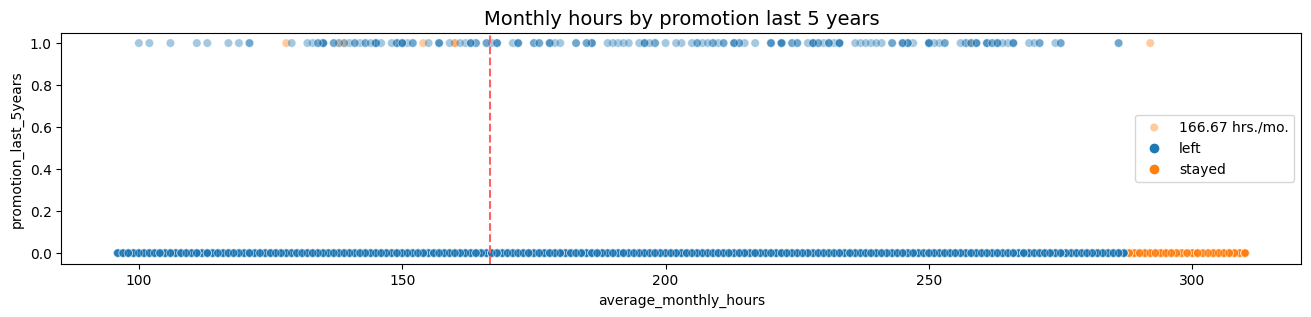

In [63]:
# Create plot to examine relationship between `average_monthly_hours` and `promotion_last_5years`
plt.figure(figsize=(16, 3))
sns.scatterplot(data=df1, x='average_monthly_hours', y='promotion_last_5years', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by promotion last 5 years', fontsize='14');

The plot above shows the following:
- very few employees who were promoted in the last five years left
- very few employees who worked the most hours were promoted
- all of the employees who left were working the longest hours  

Next, you could inspect how the employees who left are distributed across departments.

In [64]:
# Display counts for each department
df1["department"].value_counts()

sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: department, dtype: int64

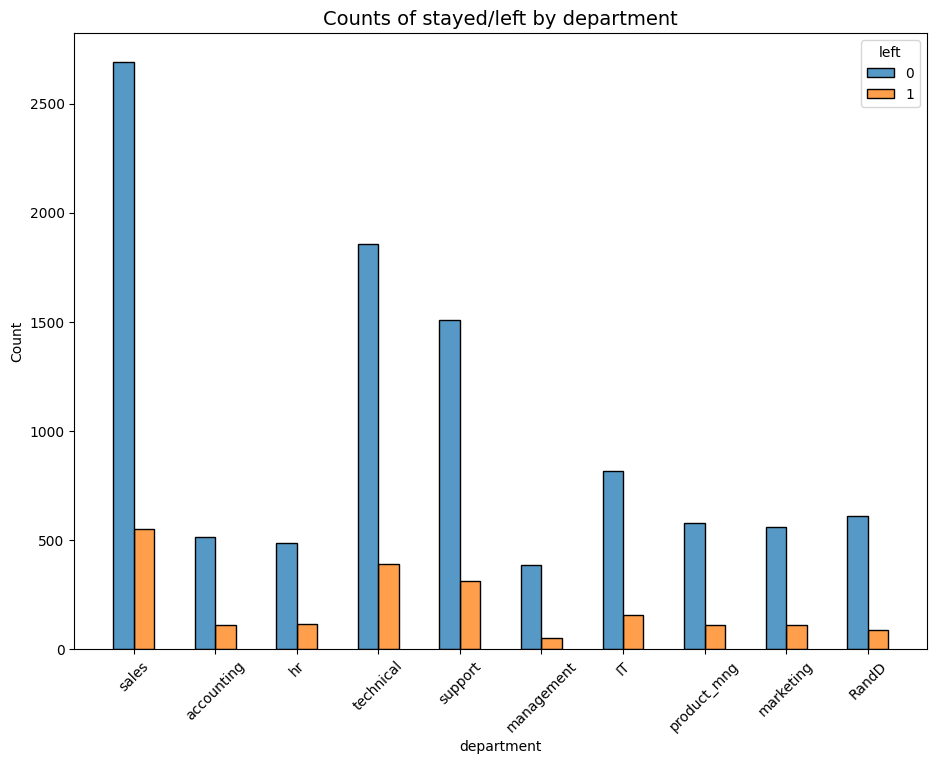

In [65]:
# Create stacked histogram to compare department distribution of employees who left to that of employees who didn't
plt.figure(figsize=(11,8))
sns.histplot(data=df1, x='department', hue='left', discrete=1, 
             hue_order=[0, 1], multiple='dodge', shrink=.5)
plt.xticks(rotation='45')
plt.title('Counts of stayed/left by department', fontsize=14);


There doesn't seem to be any department that differs significantly in its proportion of employees who left to those who stayed. 

Lastly, you could check for strong correlations between variables in the data.

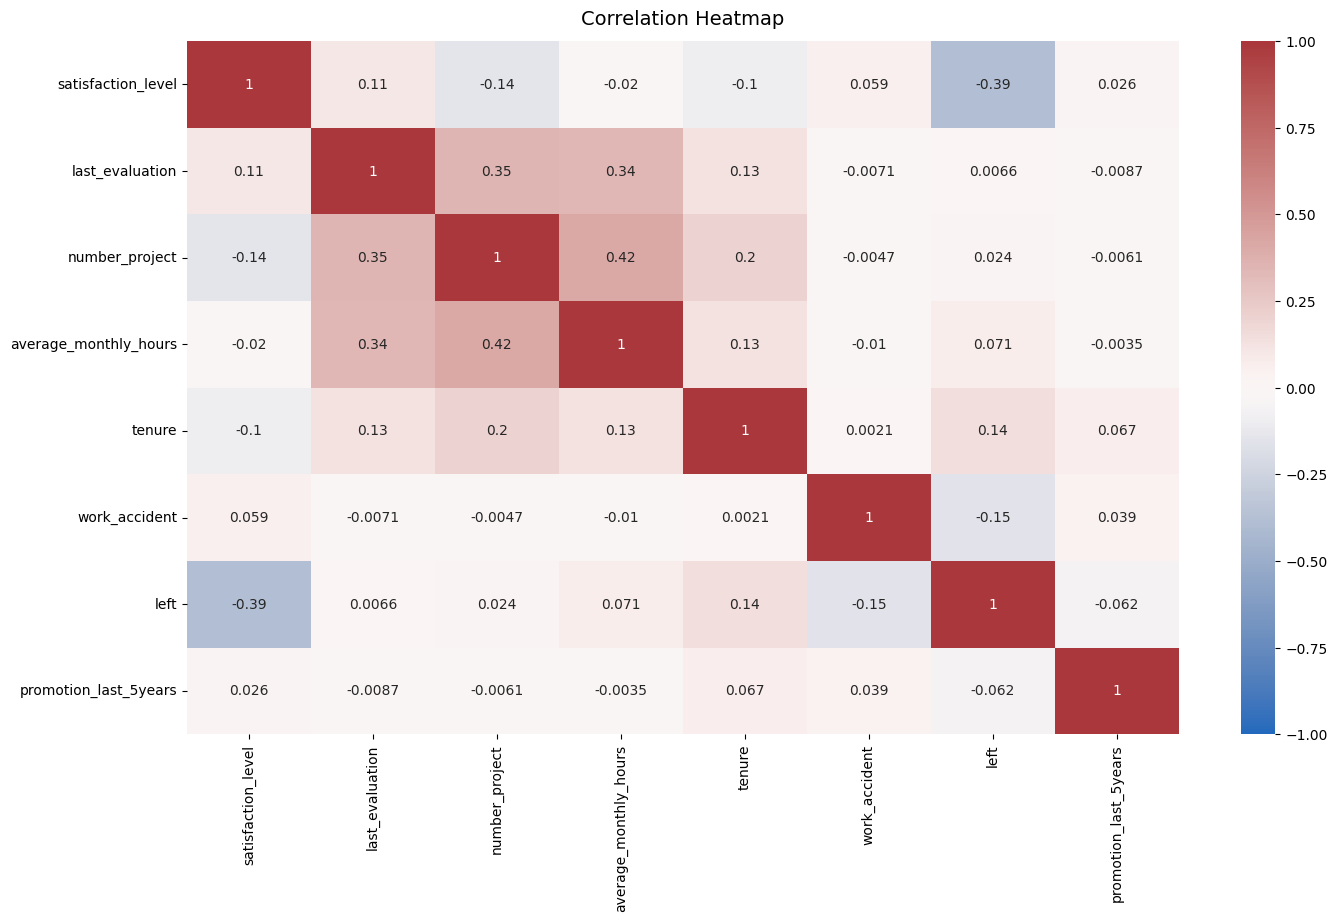

In [66]:
# Plot a correlation heatmap
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(df0.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

The correlation heatmap confirms that the number of projects, monthly hours, and evaluation scores all have some positive correlation with each other, and whether an employee leaves is negatively correlated with their satisfaction level.

### Insights

It appears that employees are leaving the company as a result of poor management. Leaving is tied to longer working hours, many projects, and generally lower satisfaction levels. It can be ungratifying to work long hours and not receive promotions or good evaluation scores. There's a sizeable group of employees at this company who are probably burned out. It also appears that if an employee has spent more than six years at the company, they tend not to leave. 

# Construct Stage
- Determine which models are most appropriate
- Construct the model 
- Confirm model assumptions
- Evaluate model results to determine how well your model fits the data


## Recall model assumptions

**Logistic Regression model assumptions**
- Outcome variable is categorical
- Observations are independent of each other
- No severe multicollinearity among X variables 
- No extreme outliers
- Linear relationship between each X variable and the logit of the outcome variable
- Sufficiently large sample size 





## Model Building. Results and Evaluation
- Fit a model that predicts the outcome variable using two or more independent variables
- Check model assumptions
- Evaluate the model

### Identify the type of prediction task.

The goal is to predict whether an employee leaves the company, which is a categorical outcome variable. So this task involves classification. More specifically, this involves binary classification, since the outcome variable `left` can be either 1 (indicating employee left) or 0 (indicating employee didn't leave). 

### Identify the types of models most appropriate for this task.

Since the variable I want to predict (whether an employee leaves the company) is categorical, so I could either build a Logistic Regression model, or a Tree-based Machine Learning model.


### Modeling Approach A: Logistic Regression Model

This approach covers implementation of Logistic Regression.

#### Logistic regression
Note that binomial logistic regression suits the task because it involves binary classification.

Before splitting the data, encode the non-numeric variables. There are two: `department` and `salary`. 

`department` is a categorical variable, which means you can dummy it for modeling. 

`salary` is categorical too, but it's ordinal. There's a hierarchy to the categories, so it's better not to dummy this column, but rather to convert the levels to numbers, 0&ndash;2.

In [67]:
# Copy the dataframe
df_enc = df1.copy()

# Encode the `salary` column as an ordinal numeric category
df_enc['salary'] = (
    df_enc['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

# Dummy encode the `department` column
df_enc = pd.get_dummies(df_enc, drop_first=False)

# Display the new dataframe
df_enc.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years  salary  department_IT  \
0       3              0     1                      0       0              0   
1       6              0     1                      0       1              0   
2       4              0     1                      0       1              0   
3       5              0     1                      0       0              0   
4       3              0     1                      0       0              0   

   department_RandD  department_accounting  department_hr  \
0                 0                      0              0   
1                 0                      0              0   
2                 0                      0              0   
3                 0                      0              0   
4                 0                      0              0   

   department_management  department_marketing  department_product_mng  \
0                      0                     0                       0   
1                      0                     0                       0   
2                      0                     0                       0   
3                      0                     0                       0   
4                      0                     0                       0   

   department_sales  department_support  department_technical  
0                 1                   0                     0  
1                 1                   0                     0  
2                 1                   0                     0  
3                 1                   0                     0  
4                 1                   0                     0

Create a heatmap to visualize how correlated variables are. Consider which variables you're interested in examining correlations between.

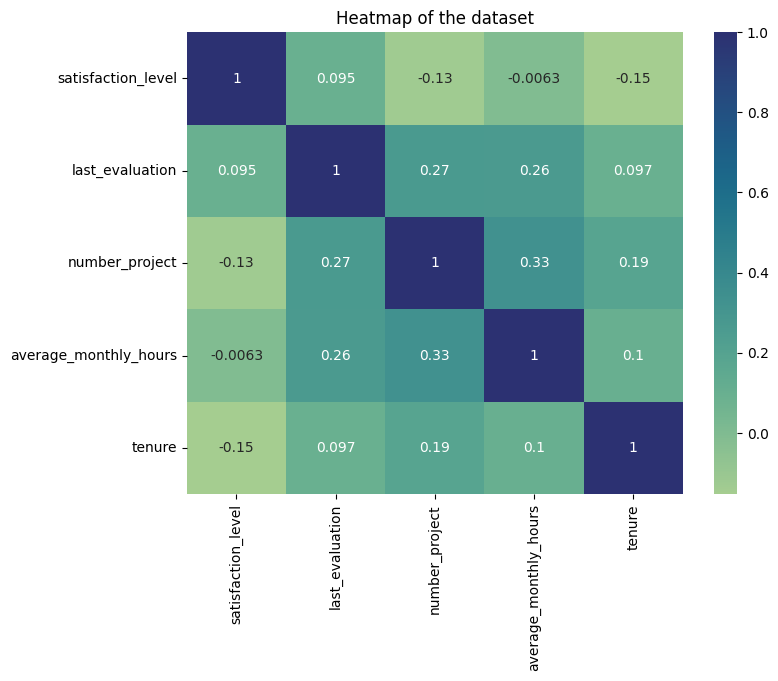

In [68]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(8, 6))
sns.heatmap(df_enc[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']]
            .corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

Create a stacked bart plot to visualize number of employees across department, comparing those who left with those who didn't.

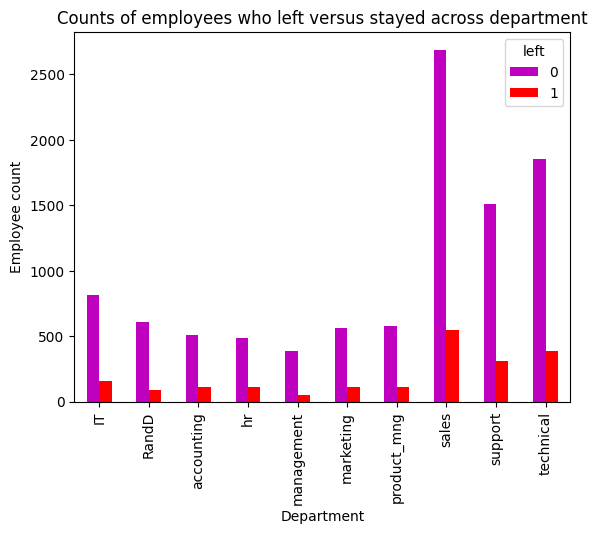

In [69]:
# Create a stacked bart plot to visualize number of employees across department, comparing those who left with those who didn't
# In the legend, 0 (purple color) represents employees who did not leave, 1 (red color) represents employees who left
pd.crosstab(df1['department'], df1['left']).plot(kind ='bar',color='mr')
plt.title('Counts of employees who left versus stayed across department')
plt.ylabel('Employee count')
plt.xlabel('Department')
plt.show()

Since logistic regression is quite sensitive to outliers, it would be a good idea at this stage to remove the outliers in the `tenure` column that were identified earlier.

In [70]:
# Select rows without outliers in `tenure` and save resulting dataframe in a new variable
df_logreg = df_enc[(df_enc['tenure'] >= lower_limit) & (df_enc['tenure'] <= upper_limit)]
# Display first few rows of new dataframe
df_logreg.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   
5                0.41             0.50               2                    153   

   tenure  work_accident  left  promotion_last_5years  salary  department_IT  \
0       3              0     1                      0       0              0   
2       4              0     1                      0       1              0   
3       5              0     1                      0       0              0   
4       3              0     1                      0       0              0   
5       3              0     1                      0       0              0   

   department_RandD  department_accounting  department_hr  \
0                 0                      0              0   
2                 0                      0              0   
3                 0                      0              0   
4                 0                      0              0   
5                 0                      0              0   

   department_management  department_marketing  department_product_mng  \
0                      0                     0                       0   
2                      0                     0                       0   
3                      0                     0                       0   
4                      0                     0                       0   
5                      0                     0                       0   

   department_sales  department_support  department_technical  
0                 1                   0                     0  
2                 1                   0                     0  
3                 1                   0                     0  
4                 1                   0                     0  
5                 1                   0                     0

Isolate the outcome variable, which is the variable you want your model to predict.

In [71]:
# Isolate the outcome variable
y = df_logreg['left']
# Display first few rows of the outcome variable
y.head() 

0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

Select the features want to use in your model. Consider which variables will help me predict the outcome variable, `left`.

In [72]:
# Select the features you want to use in your model
X = df_logreg.drop('left', axis=1)
X.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   
5                0.41             0.50               2                    153   

   tenure  work_accident  promotion_last_5years  salary  department_IT  \
0       3              0                      0       0              0   
2       4              0                      0       1              0   
3       5              0                      0       0              0   
4       3              0                      0       0              0   
5       3              0                      0       0              0   

   department_RandD  department_accounting  department_hr  \
0                 0                      0              0   
2                 0                      0              0   
3                 0                      0              0   
4                 0                      0              0   
5                 0                      0              0   

   department_management  department_marketing  department_product_mng  \
0                      0                     0                       0   
2                      0                     0                       0   
3                      0                     0                       0   
4                      0                     0                       0   
5                      0                     0                       0   

   department_sales  department_support  department_technical  
0                 1                   0                     0  
2                 1                   0                     0  
3                 1                   0                     0  
4                 1                   0                     0  
5                 1                   0                     0

Split the data into training set and testing set.

In [73]:
# Split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

Construct a logistic regression model and fit it to the training dataset.

In [74]:
# Construct a logistic regression model and fit it to the training dataset
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

Test the logistic regression model: use the model to make predictions on the test set.

In [75]:
# Use the logistic regression model to get predictions on the test set
y_pred = log_clf.predict(X_test)

Create a confusion matrix to visualize the results of the logistic regression model. 

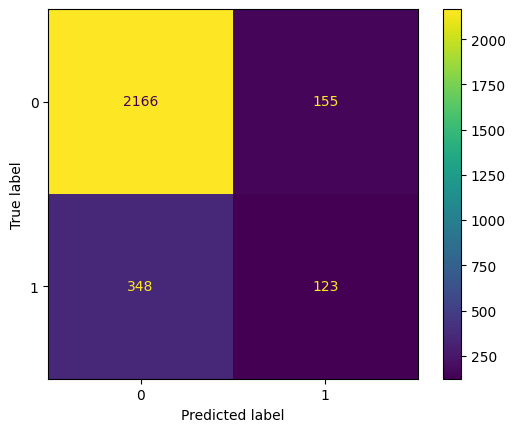

In [76]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)
# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_clf.classes_)
# Plot confusion matrix
log_disp.plot(values_format='')
# Display plot
plt.show()

The upper-left quadrant displays the number of true negatives.
The upper-right quadrant displays the number of false positives.
The bottom-left quadrant displays the number of false negatives.
The bottom-right quadrant displays the number of true positives.

True negatives: The number of people who did not leave that the model accurately predicted did not leave.

False positives: The number of people who did not leave the model inaccurately predicted as leaving.

False negatives: The number of people who left that the model inaccurately predicted did not leave

True positives: The number of people who left the model accurately predicted as leaving

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

Create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the logistic regression model.

Check the class balance in the data. In other words, check the value counts in the `left` column. Since this is a binary classification task, the class balance informs the way  interpret accuracy metrics.

In [77]:
df_logreg['left'].value_counts(normalize=True)

0    0.831468
1    0.168532
Name: left, dtype: float64

There is an approximately 83%-17% split. So the data is not perfectly balanced, but it is not too imbalanced. If it was more severely imbalanced, might want to resample the data to make it more balanced. In this case, use this data without modifying the class balance and continue evaluating the model.

In [78]:
# Create classification report for logistic regression model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.93      0.90      2321
    Predicted would leave       0.44      0.26      0.33       471

                 accuracy                           0.82      2792
                macro avg       0.65      0.60      0.61      2792
             weighted avg       0.79      0.82      0.80      2792



The classification report above shows that the logistic regression model achieved a precision of 79%, recall of 82%, f1-score of 80% (all weighted averages), and accuracy of 82%. However, if it's most important to predict employees who leave, then the scores are significantly lower.

### Modeling Approach B: Tree-based Model
This approach covers implementation of Decision Tree and Random Forest. 

Isolate the outcome variable.

In [79]:
# Isolate the outcome variable
y = df_enc['left']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

Select the features. 

In [80]:
# Select the features
X = df_enc.drop('left', axis=1)
X.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  promotion_last_5years  salary  department_IT  \
0       3              0                      0       0              0   
1       6              0                      0       1              0   
2       4              0                      0       1              0   
3       5              0                      0       0              0   
4       3              0                      0       0              0   

   department_RandD  department_accounting  department_hr  \
0                 0                      0              0   
1                 0                      0              0   
2                 0                      0              0   
3                 0                      0              0   
4                 0                      0              0   

   department_management  department_marketing  department_product_mng  \
0                      0                     0                       0   
1                      0                     0                       0   
2                      0                     0                       0   
3                      0                     0                       0   
4                      0                     0                       0   

   department_sales  department_support  department_technical  
0                 1                   0                     0  
1                 1                   0                     0  
2                 1                   0                     0  
3                 1                   0                     0  
4                 1                   0                     0

Split the data into training, validating, and testing sets.

In [81]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

#### Decision tree - Round 1

Construct a decision tree model and set up cross-validated grid-search to exhuastively search for the best model parameters.

In [82]:
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

Fit the decision tree model to the training data.

In [83]:
%%time
tree1.fit(X_train, y_train)

Wall time: 5.06 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'f1', 'precision', 'recall', 'accuracy', 'roc_auc'})

Identify the optimal values for the decision tree parameters.

In [84]:
# Check best parameters
tree1.best_params_

{'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}

Identify the best AUC score achieved by the decision tree model on the training set.

In [85]:
# Check best AUC score on CV
tree1.best_score_

0.969819392792457

This is a strong AUC score, which shows that this model can predict employees who will leave very well.

Next, write a function that will help you extract all the scores from the grid search. 

In [86]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc
  
    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

Use the function just defined to get all the scores from grid search.

In [87]:
# Get all CV scores
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.914552  0.916949  0.915707  0.971978  0.969819

All of these scores from the decision tree model are strong indicators of good model performance. 

Recall that decision trees can be vulnerable to overfitting, and random forests avoid overfitting by incorporating multiple trees to make predictions so construct a random forest model next.

#### Random forest - Round 1

Construct a random forest model and set up cross-validated grid-search to exhuastively search for the best model parameters.

In [88]:
# Instantiate model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

Fit the random forest model to the training data.

In [89]:
%%time
rf1.fit(X_train, y_train) # --> Wall time: ~10min

Wall time: 26min 19s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'f1', 'precision', 'recall', 'accuracy', 'roc_auc'})

In [115]:
# Define a path to the folder 
path = 'data/'

Define functions to pickle the model and read in the model.

In [116]:
def write_pickle(path, model_object, save_as:str):
    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [117]:
def read_pickle(path, saved_model_name:str):
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

Use the functions defined above to save the model in a pickle file and then read it in.

In [118]:
# Write pickle
write_pickle(path, rf1, 'hr_rf1')

In [119]:
# Read pickle
rf1 = read_pickle(path, 'hr_rf1')

Identify the best AUC score achieved by the random forest model on the training set.

In [120]:
# Check best AUC score on CV
rf1.best_score_

0.9804250949807172

Identify the optimal values for the parameters of the random forest model.

In [121]:
# Check best params
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 500}

Collect the evaluation scores on the training set for the decision tree and random forest models.

In [122]:
# Get all CV scores
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
print(tree1_cv_results)
print(rf1_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.914552  0.916949  0.915707  0.971978  0.969819
              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.950023  0.915614  0.932467  0.977983  0.980425


Define a function that gets all the scores from a model's predictions.

In [123]:
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })
  
    return table

Now use the best performing model to predict on the test set.

In [124]:
# Get predictions on test data
rf1_test_scores = get_scores('random forest1 test', rf1, X_test, y_test)
rf1_test_scores

model  precision    recall        f1  accuracy       AUC
0  random forest1 test   0.964211  0.919679  0.941418  0.980987  0.956439

The test scores are very similar to the validation scores, which is good. This appears to be a strong model. Since this test set was only used for this model, you can be more confident that your model's performance on this data is representative of how it will perform on new, unseeen data.

In [125]:
df2 = df_enc.drop('satisfaction_level', axis=1)
df2.head()

last_evaluation  number_project  average_monthly_hours  tenure  \
0             0.53               2                    157       3   
1             0.86               5                    262       6   
2             0.88               7                    272       4   
3             0.87               5                    223       5   
4             0.52               2                    159       3   

   work_accident  left  promotion_last_5years  salary  department_IT  \
0              0     1                      0       0              0   
1              0     1                      0       1              0   
2              0     1                      0       1              0   
3              0     1                      0       0              0   
4              0     1                      0       0              0   

   department_RandD  department_accounting  department_hr  \
0                 0                      0              0   
1                 0                      0              0   
2                 0                      0              0   
3                 0                      0              0   
4                 0                      0              0   

   department_management  department_marketing  department_product_mng  \
0                      0                     0                       0   
1                      0                     0                       0   
2                      0                     0                       0   
3                      0                     0                       0   
4                      0                     0                       0   

   department_sales  department_support  department_technical  
0                 1                   0                     0  
1                 1                   0                     0  
2                 1                   0                     0  
3                 1                   0                     0  
4                 1                   0                     0

In [126]:
# Create `overworked` column. For now, it's identical to average monthly hours.
df2['overworked'] = df2['average_monthly_hours']

# Inspect max and min average monthly hours values
print('Max hours:', df2['overworked'].max())
print('Min hours:', df2['overworked'].min())

Max hours: 310
Min hours: 96


166.67 is approximately the average number of monthly hours for someone who works 50 weeks per year, 5 days per week, 8 hours per day. 

You could define being overworked as working more than 175 hours per month on average.

To make the `overworked` column binary,reassign the column using a boolean mask.
- `df3['overworked'] > 175` creates a series of booleans, consisting of `True` for every value > 175 and `False` for every values ≤ 175
- `.astype(int)` converts all `True` to `1` and all `False` to `0` 

In [127]:
# Define `overworked` as working > 175 hrs/week
df2['overworked'] = (df2['overworked'] > 175).astype(int)
df2['overworked'].head()

0    0
1    1
2    1
3    1
4    0
Name: overworked, dtype: int32

Drop the `average_monthly_hours` column.



In [128]:
# Drop the `average_monthly_hours` column
df2 = df2.drop('average_monthly_hours', axis=1)
df2.head()

last_evaluation  number_project  tenure  work_accident  left  \
0             0.53               2       3              0     1   
1             0.86               5       6              0     1   
2             0.88               7       4              0     1   
3             0.87               5       5              0     1   
4             0.52               2       3              0     1   

   promotion_last_5years  salary  department_IT  department_RandD  \
0                      0       0              0                 0   
1                      0       1              0                 0   
2                      0       1              0                 0   
3                      0       0              0                 0   
4                      0       0              0                 0   

   department_accounting  department_hr  department_management  \
0                      0              0                      0   
1                      0              0                      0   
2                      0              0                      0   
3                      0              0                      0   
4                      0              0                      0   

   department_marketing  department_product_mng  department_sales  \
0                     0                       0                 1   
1                     0                       0                 1   
2                     0                       0                 1   
3                     0                       0                 1   
4                     0                       0                 1   

   department_support  department_technical  overworked  
0                   0                     0           0  
1                   0                     0           1  
2                   0                     0           1  
3                   0                     0           1  
4                   0                     0           0

Again, isolate the features and target variables

In [129]:
# Isolate the outcome variable
y = df2['left']

# Select the features
X = df2.drop('left', axis=1)

Split the data into training and testing sets.

In [130]:
# Create test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

#### Decision tree - Round 2

In [131]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=0)
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
tree2 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [132]:
%%time
tree2.fit(X_train, y_train)

Wall time: 4.76 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'f1', 'precision', 'recall', 'accuracy', 'roc_auc'})

In [133]:
# Check best params
tree2.best_params_

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}

In [134]:
# Check best AUC score on CV
tree2.best_score_

0.9586752505340426

This model performs very well, even without satisfaction levels and detailed hours worked data. 

Next, check the other scores.

In [135]:
# Get all CV scores
tree2_cv_results = make_results('decision tree2 cv', tree2, 'auc')
print(tree1_cv_results)
print(tree2_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.914552  0.916949  0.915707  0.971978  0.969819
               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.856693  0.903553  0.878882  0.958523  0.958675


Some of the other scores fell. That's to be expected given fewer features were taken into account in this round of the model. Still, the scores are very good.

#### Random forest - Round 2

In [136]:
rf = RandomForestClassifier(random_state=0)

cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

rf2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [137]:
%%time
rf2.fit(X_train, y_train) # --> Wall time: 7min 5s

Wall time: 21min 44s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'f1', 'precision', 'recall', 'accuracy', 'roc_auc'})

In [138]:
write_pickle(path, rf2, 'hr_rf2')

In [139]:
# Read in pickle
rf2 = read_pickle(path, 'hr_rf2')

In [140]:
# Check best params
rf2.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [144]:
# Check best AUC score on CV
rf2.best_score_

0.9648100662833985

In [143]:
# Get all CV scores
rf2_cv_results = make_results('random forest2 cv', rf2, 'auc')
print(tree2_cv_results)
print(rf2_cv_results)

               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.856693  0.903553  0.878882  0.958523  0.958675
               model  precision    recall        F1  accuracy      auc
0  random forest2 cv   0.866758  0.878754  0.872407  0.957411  0.96481


Again, the scores dropped slightly, but the random forest performs better than the decision tree if using AUC as the deciding metric. 

Score the champion model on the test set now.

In [142]:
# Get predictions on test data
rf2_test_scores = get_scores('random forest2 test', rf2, X_test, y_test)
rf2_test_scores

model  precision    recall      f1  accuracy       AUC
0  random forest2 test   0.870406  0.903614  0.8867  0.961641  0.938407

This seems to be a stable, well-performing final model. 

Plot a confusion matrix to visualize how well it predicts on the test set.

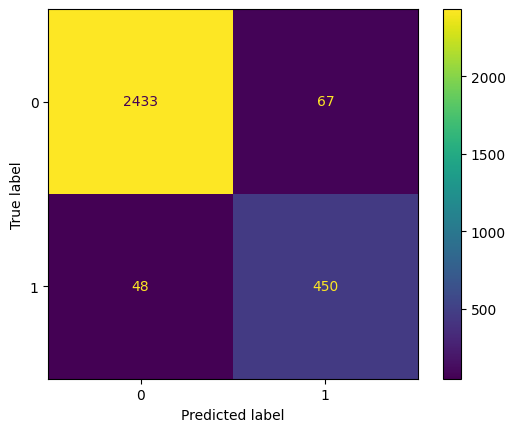

In [141]:
# Generate array of values for confusion matrix
preds = rf2.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf2.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf2.classes_)
disp.plot(values_format='');

The model predicts more false positives than false negatives, which means that some employees may be identified as at risk of quitting or getting fired, when that's actually not the case. But this is still a strong model.

#### Decision tree splits

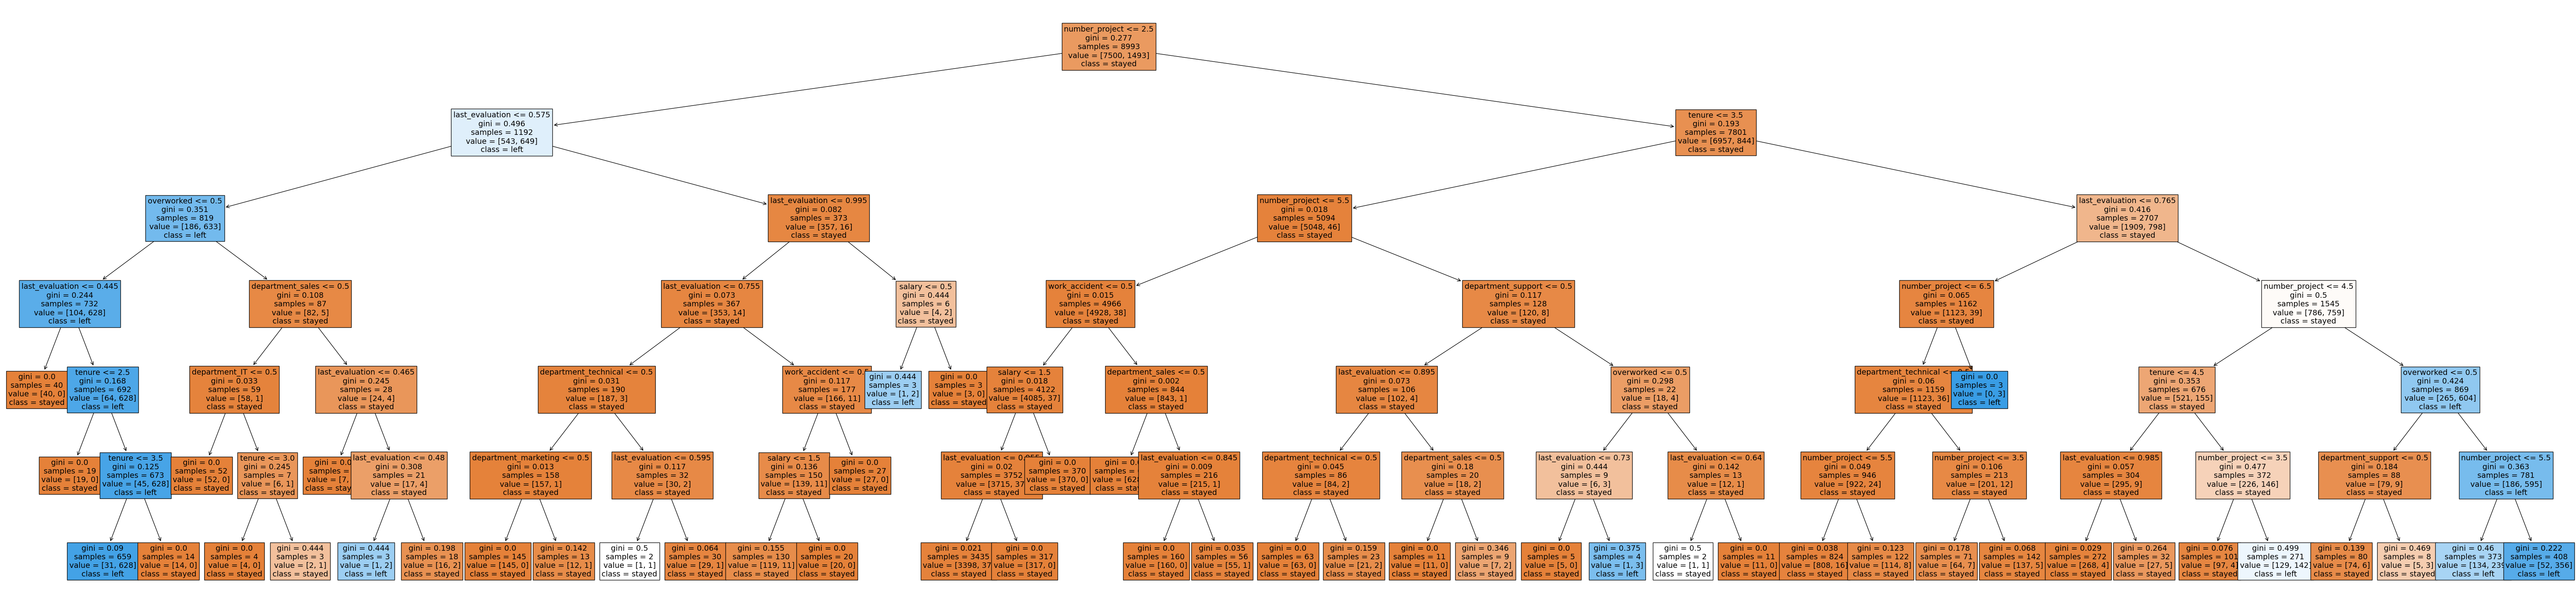

In [145]:
# Plot the tree
plt.figure(figsize=(85,20))
plot_tree(tree2.best_estimator_, max_depth=6, fontsize=14, feature_names=X.columns, 
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

#### Decision tree feature importance


In [79]:
#tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, columns=X.columns)
tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
tree2_importances = tree2_importances[tree2_importances['gini_importance'] != 0]
tree2_importances

gini_importance
last_evaluation              0.343958
number_project               0.343385
tenure                       0.215681
overworked                   0.093498
department_support           0.001142
salary                       0.000910
department_sales             0.000607
department_technical         0.000418
work_accident                0.000183
department_IT                0.000139
department_marketing         0.000078

Create a barplot to visualize the decision tree feature importances.

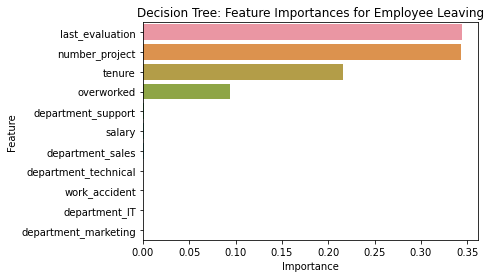

In [80]:
sns.barplot(data=tree2_importances, x="gini_importance", y=tree2_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()


The barplot above shows that in this decision tree model, `last_evaluation`, `number_project`, `tenure`, and `overworked` have the highest importance, in that order. These variables are most helpful in predicting the outcome variable, `left`.

#### Random forest feature importance

Now, plot the feature importances for the random forest model.

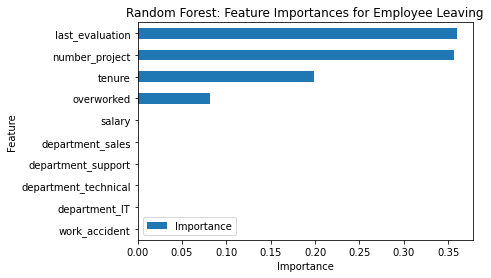

In [81]:
# Get feature importances
feat_impt = rf2.best_estimator_.feature_importances_
# Get indices of top 10 features
ind = np.argpartition(rf2.best_estimator_.feature_importances_, -10)[-10:]
# Get column labels of top 10 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

The plot above shows that in this random forest model, `last_evaluation`, `number_project`, `tenure`, and `overworked` have the highest importance, in that order. These variables are most helpful in predicting the outcome variable, `left`, and they are the same as the ones used by the decision tree model.

## Results and Evaluation
- Interpret model
- Evaluate model performance using metrics
- Prepare results, visualizations, and actionable steps to share with stakeholders




### Summary of model results

**Logistic Regression**

The logistic regression model achieved precision of 80%, recall of 83%, f1-score of 80% (all weighted averages), and accuracy of 83%, on the test set.

**Tree-based Machine Learning**

After conducting feature engineering, the decision tree model achieved AUC of 93.8%, precision of 87.0%, recall of 90.4%, f1-score of 88.7%, and accuracy of 96.2%, on the test set. The random forest modestly outperformed the decision tree model. 

### Conclusion

The models and the feature importances extracted from the models confirm that employees at the company are overworked. 

To retain employees, the following recommendations could be presented to the stakeholders:

* Cap the number of projects that employees can work on.
* Consider promoting employees who have been with the company for atleast four years, or conduct further investigation about why four-year tenured employees are so dissatisfied. 
* Either reward employees for working longer hours, or don't require them to do so. 
* If employees aren't familiar with the company's overtime pay policies, inform them about this. If the expectations around workload and time off aren't explicit, make them clear. 
* Hold company-wide and within-team discussions to understand and address the company work culture, across the board and in specific contexts. 
* High evaluation scores should not be reserved for employees who work 200+ hours per month. Consider a proportionate scale for rewarding employees who contribute more/put in more effort. 

